# A notebook for pulling the run data from wandb for TALES and creating the various figures and tables used in our paper and website.

## Data pre-processing
Relevant Variables:
- tmp: dataframe with all of the run info
- framework_games: a dictionary of the form {framework: [all games in framework]}. Useful for checking and making sure that every llm has at least one game run
- llm_framework_scores: a dictionary of the form {llm: {framework: {game: {seed: [best_score, tokens_used]}}}}

### These cells do the following:
- Initialize the wandb api
- Pull all the runs according to certain filters ('conversation: True')
- Dump the runs into a pandas dataframe
- Print the number of total games per llm (This should be 615 if all games were run 615 = 123 * 5)

In [1]:
#Workspace you want to pull runs from
wandb_workspace = "text-games-benchmark"

# Where you want the logged format texts to be stored (option for more complicated file structures later down)
base_path = '/root/logs/'

# Divider between each step. Change as wanted
divider_string = "\n************************************************************************************************\n"

# The specific chain of thought prompt: probably not needed, will remove in the future
COT_SYS_PROMPT = """You are playing a text-based game and your goal is to finish it with the highest score. Upon reading the text observation, generate a plan with subgoals when asked to think step-by-step, then provide a *single* short phrase to interact with the game when asked to do so, e.g. `get lamp` (without the backticks). When stuck, try using the `help` command to see what commands are available."""

In [2]:
import wandb
import os
import json
import numpy as np

api = wandb.Api()

In [ ]:
import pandas as pd
filter ={
            "config.conversation": True,
        }

runs = api.runs(path="text-games-benchmark", filters = filter)
run_cutoff = "2024-02-0"
files_skipped = 0
path = base_path # Change to your file path
runs_data = []
for run in runs:
    if 'without-help' not in run.tags:
        run_data = dict(run.summary)
        run_data.update(run.config)
        run_data['tags'] = run.tags
        run_data['run_object'] = run

        # Download the artifact to extract the rollout. This can take a while if you haven't downloaded them before so I would recommend commenting them out if not needed
        file_path = run._summary['episode/rollout']['path']
        full_path = path + file_path
        try:
            if not os.path.exists(full_path): # If the log has not been downloaded, download it
                print("Downloading file", full_path)
                for file in run.files():
                    if "rollout" in file.name:
                        file.download(base_path, exist_ok=True)
            with open(full_path) as json_file: log = json.load(json_file)
            run_data['rollout'] = log['data']
        except:
            print("Could not get trajectory for run", run.name)
            files_skipped += 1
            if files_skipped > 5:
                break

        # run_data["agent"] = run.config["agent"]
        # run_data["game"] = run.config["game"]
        runs_data.append(run_data)
print(len(runs_data))
runs_df = pd.DataFrame(runs_data)

In [5]:
# Filter the runs
tmp = runs_df
tmp = tmp[tmp['conversation'] == True]
tmp1 = tmp[tmp['agent_type'] == 'zero-shot']
tmp2 = tmp[tmp['agent_type'] == 'react']
# tmp = tmp[tmp['agent_type'] == 'zero-shot']
tmp = pd.concat([tmp1, tmp2])
tmp = tmp[tmp['llm'] != 'claude-3.5-sonnet']
tmp = tmp[~tmp['tags'].apply(lambda tags: 'without-help' in tags)]
llm_counts = tmp[['llm', 'seed', 'game']].groupby('llm').size().reset_index(name='total_games')

print(llm_counts)

                                                  llm  total_games
0                           Qwen/Qwen2.5-72B-Instruct          615
1                            Qwen/Qwen2.5-7B-Instruct          615
2                                    claude-3.5-haiku          615
3                            claude-3.5-sonnet-latest          615
4                                   claude-3.7-sonnet          615
5                             deepseek-ai/DeepSeek-R1          367
6           deepseek-ai/DeepSeek-R1-Distill-Llama-70B          488
7                                    gemini-2.0-flash           75
8                            gemini-2.5-pro-exp-03-25            1
9                        gemini-2.5-pro-preview-03-25           51
10                                             gpt-4o          615
11                                        gpt-4o-mini          615
12                 meta-llama/Llama-3.1-405B-Instruct          615
13                  meta-llama/Llama-3.1-70B-Instruct         

### Get a dictionary of the form {llm: {framework: {game: {seed: best_score}}}} to make things easier later

In [6]:
import random
num_runs = 0
num_traj = 0
avg_last_rewarded_step = 0
rewarded_trajs = 0
filtered_runs_data = tmp.to_dict(orient='records')
data = random.choice(filtered_runs_data)
print(data.keys())
all_frameworks = tmp['framework'].unique()
all_llms = tmp['llm'].unique()
print(all_frameworks)
# Could just do tmp['framework'].unique() but this enforces ordering
fws = ['textworld', 'textworld_express', 'alfworld', 'scienceworld', 'jericho']
# store everything in a dictionary of the form {llm: {framework: {game: {seed: best_score}}}}
llm_framework_scores = {} 

# Iniitialize the LLM layer of the dictionary
for llm in all_llms:
    llm_framework_scores[llm] = {}

# Initialize the framework layer of the dictionary
for framework in fws:
    for llm in all_llms:
        llm_framework_scores[llm][framework] = {}   

# For game and seeds, its easier to just iterate through the filtered_runs_data
for data in filtered_runs_data:
    game = data['game']
    seed = data['seed']

    if game not in llm_framework_scores[data['llm']][data['framework']].keys():
        llm_framework_scores[data['llm']][data['framework']][game] = {}
    

    # Get the max score reached
    max_score = -1000000
    if 'rollout' not in data.keys():
        llm_framework_scores[data['llm']][data['framework']][game][seed] = 0
        continue
    for step in data['rollout']:
        if step[3] > max_score:
            max_score = step[3]

    tokens_used = data['episode/token_usage']
    llm_framework_scores[data['llm']][data['framework']][game][seed] = [max_score, tokens_used]

# Uncomment to count the number of runs for each LLM to sanity check
# for llm in all_llms:
#     total_runs = 0
#     for framework in fws:
#         relevant_games = llm_framework_scores[llm][framework]
#         for game, seeds in relevant_games.items():
#             total_runs += len(seeds)
#     print("LLM: ", llm)
#     print("Total runs: ", total_runs)

dict_keys(['_runtime', '_step', '_timestamp', '_wandb', 'episode/moves', 'episode/normalized_score', 'episode/rollout', 'episode/score', 'final/Duration', 'final/Game Max Score', 'final/Highscore', 'final/Normalized Score', 'total/Env. Steps', 'total/Game Moves', 'total/Invalid Actions', 'total/Losts', 'total/Resets', 'total/Wins', 'llm', 'game', 'seed', 'agent', 'context', 'act_temp', 'framework', 'max_steps', 'conversation', 'admissible_commands', 'tags', 'run_object', 'rollout', 'total/Tokens', 'cot_temp', 'game_seed', 'context_limit', 'episode/highscore', 'episode/normalized_highscore', 'episode/token_usage', 'agent_type', 'version', 'reasoning_effort'])
['scienceworld' 'textworld' 'alfworld' 'jericho' 'textworld_express']


### Make a dictionary of all frameworks and games
- Useful for when you want to check that every game has at least one run. Of the form {framework: [games]}

In [7]:
# Make a dictionary of the form {framework: [games]} to make things easier
framework_games = {}
for framework in fws:
    framework_games[framework] = []
    for llm in all_llms:
        relevant_games = llm_framework_scores[llm][framework]
        for game, seeds in relevant_games.items():
            if game not in framework_games[framework]:
                framework_games[framework].append(game)

print(framework_games)

{'textworld': ['TWCookingLevel1', 'TWCookingLevel2', 'TWCookingLevel3', 'TWCookingLevel4', 'TWCookingLevel5', 'TWCookingLevel6', 'TWCookingLevel7', 'TWCookingLevel8', 'TWCookingLevel9', 'TWCookingLevel10'], 'textworld_express': ['TWXCookingWorld', 'TWXTextWorldCommonsense', 'TWXCoinCollector', 'TWXArithmetic', 'TWXMapReader', 'TWXSorting', 'TWXSimonSays10', 'TWXSimonSays50', 'TWXSimonSays100', 'TWXSimonSaysWithMemory10', 'TWXSimonSaysWithMemory50', 'TWXSimonSaysWithMemory100', 'TWXSimonSaysWithMemory10Verbose', 'TWXSimonSaysWithMemory50Verbose', 'TWXSimonSaysWithMemory100Verbose', 'TWXPeckingOrder'], 'alfworld': ['ALFWorldPickAndPlaceSimpleSeen', 'ALFWorldLookAtObjInLightSeen', 'ALFWorldPickCleanThenPlaceInRecepSeen', 'ALFWorldPickHeatThenPlaceInRecepSeen', 'ALFWorldPickCoolThenPlaceInRecepSeen', 'ALFWorldPickTwoObjAndPlaceSeen', 'ALFWorldPickAndPlaceSimpleUnseen', 'ALFWorldLookAtObjInLightUnseen', 'ALFWorldPickCleanThenPlaceInRecepUnseen', 'ALFWorldPickHeatThenPlaceInRecepUnseen', 'AL

## Making and formatting table for overleaf
- Alot of these I made it so that the output of the cell can just be copy-pasted into the appropriate table

### Get all of the scores and stds
- Need to run this for all of the following tables/charts

In [50]:
import numpy as np

def cast_to_float(s):
    try:
        return round(float(s), 3)
    except ValueError:
        return None  # Return None if the conversion fails
    
def get_all_scores_and_stds(llms, frameworks, require_all_frameworks = True, require_all_games = True, require_all_seeds = False, skip_llms = ['claude-3.5-sonnet'], skip_frameworks = [], verbose = False):
    scores_per_framework = []
    stds_per_framework = []
    # Literate through all llms:
    for llm in llms:
        # Skip the LLMs that are not in the list
        if llm in skip_llms: continue
        # Put the llm in the first position in the list
        scores = [llm]
        stds = [llm]
        all_framework_scores = []
        all_framework_stds = []
        all_frameworks = []
        for framework in frameworks:
            # Grab the relevant games for the framework
            relevant_games = llm_framework_scores[llm][framework]

            all_tokens = []
            all_scores = []
            all_stds = []
            all_games = []
            for game, seeds in relevant_games.items():
                # Get the scores for the game per seed:
                token_seeds = []
                score_seeds = []
                all_games.append(game)
                for score_tokens in seeds.values():
                    score_seeds.append(score_tokens[0])
                    token_seeds.append(score_tokens[1])
                all_scores.append(np.mean(score_seeds))
                all_stds.append(np.std(score_seeds))
                all_tokens.append(np.mean(token_seeds))
                all_framework_scores.append(all_scores[-1])
                all_framework_stds.append(all_stds[-1])

            # if we are requiring all games, check if we have all the games
            missing_games = []
            if require_all_games:
                for game in framework_games[framework]: 
                    if game not in all_games: missing_games.append(game)
                if len(missing_games) != 0: 
                    if verbose: print(f'{llm} missing games {",".join(missing_games)} in {framework}')
                    continue

            # if we are requiring all seeds, check if we have all the seeds
            if require_all_seeds:
                for game, seeds in relevant_games.items(): 
                    if len(seeds) != 5: missing_games.append(game)
                if len(missing_games) != 0:
                    if verbose: print(f'{llm} missing seeds {",".join(missing_games)} in {framework}')
                    continue

            all_frameworks.append(framework)
            scores.append(cast_to_float(np.mean(all_scores)))
            stds.append(cast_to_float(np.mean(all_stds)))

        # if we are requiring all frameworks, check if we have all the frameworks
        if require_all_frameworks:
            if len(scores) != len(frameworks) + 1: # +1 offset for the llm
                missing_frameworks = []
                for framework in frameworks: 
                    if framework not in all_frameworks: missing_frameworks.append(framework)
                if len(missing_frameworks) != 0:
                    if verbose: print(f'{llm} missing frameworks {",".join(missing_frameworks)}')
                    continue

        # Append the per-game mean of all the scores to the end
        scores.append(cast_to_float(np.mean(all_framework_scores)))
        scores_per_framework.append(scores) 

        # Append the per-game mean of all of the standard deviations to the end
        stds.append(cast_to_float(np.mean(all_framework_stds)))
        stds_per_framework.append(stds)
    
    return scores_per_framework, stds_per_framework

scores_per_framework, stds_per_framework = get_all_scores_and_stds(
                                            llms = all_llms, 
                                            frameworks = fws, 
                                            require_all_frameworks = True, 
                                            require_all_games = True, 
                                            require_all_seeds = False, 
                                            skip_llms = ['claude-3.5-sonnet'], 
                                            skip_frameworks = [], 
                                            verbose = False)

### Print out a latex-formatted table of scores

In [38]:
def cast_to_str(value, sig_digits=3):
    if value == 0: return '0.' + '0' * sig_digits
    
    # Count sig figs after decimal
    sig_figs = len(str(value).split(".")[-1])

    # Count zeros to be added:
    trailing_zeros = sig_digits - sig_figs
    
    # Pad zeros
    string_value = str(value)
    for i in range(trailing_zeros): string_value += "0"

    return string_value

def sort_by_last_element(arr):
    return sorted(arr, key=lambda x: x[-1], reverse = True)

sorted_array = sort_by_last_element(scores_per_framework)
print("Model, Textworld, Textworld_express, Alfworld, Scienceworld, Jericho, Overall")

# Padding them to have the &s line up because it makes my ocd happy
formatted_rows = []
for model in sorted_array:
    formattedRow = [model[0].split("/")[-1]]
    for score in model[1:]:
        formattedRow.append(cast_to_str((cast_to_float(score))))
    formatted_rows.append(formattedRow)

max_model_len = max([len(row[0]) for row in formatted_rows])

for row in formatted_rows:
    scores = " & ".join(row[1:])
    print(f"{row[0]:<{max_model_len + 2}} {scores}")



Model, Textworld, Textworld_express, Alfworld, Scienceworld, Jericho, Overall
claude-3.7-sonnet                        0.973 & 0.913 & 0.833 & 0.765 & 0.123 & 0.521
claude-3.5-sonnet-latest                 0.955 & 0.816 & 0.750 & 0.823 & 0.095 & 0.500
o1                                       0.978 & 0.700 & 0.283 & 0.801 & 0.100 & 0.438
gpt-4o                                   0.836 & 0.806 & 0.567 & 0.614 & 0.055 & 0.402
claude-3.5-haiku                         0.949 & 0.798 & 0.267 & 0.673 & 0.049 & 0.393
Llama-3.1-405B-Instruct                  0.909 & 0.792 & 0.317 & 0.518 & 0.060 & 0.361
Llama-3.3-70B-Instruct                   0.696 & 0.772 & 0.150 & 0.551 & 0.044 & 0.326
Llama-3.1-70B-Instruct                   0.656 & 0.819 & 0.083 & 0.519 & 0.052 & 0.318
Qwen2.5-72B-Instruct                     0.765 & 0.838 & 0.367 & 0.350 & 0.028 & 0.305
Mistral-Large-Instruct-2407              0.824 & 0.683 & 0.067 & 0.461 & 0.057 & 0.300
gpt-4o-mini                              0.565 & 0.7

### Make a bar chart

8


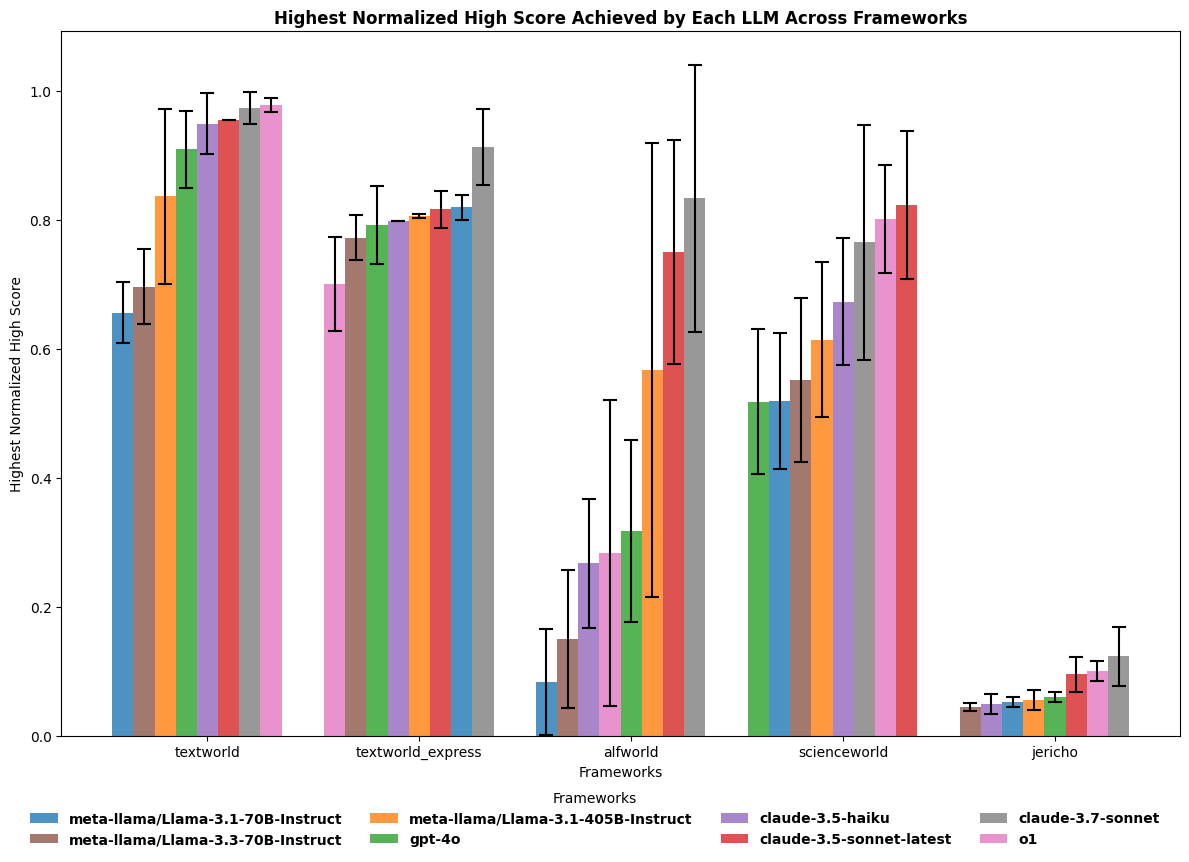

In [73]:
import matplotlib.pyplot as plt
import numpy as np
def make_bar_chart(llms, frameworks):
    framework_indicies = []
    for framework in frameworks:
        framework_indicies.append(fws.index(framework) + 1) # +1 to deal with model name offset
    framework_indicies = sorted(framework_indicies)

    # Filter the scores_per_framework array based on the llms and frameworks
    # Filter the stds_per_framework array based on the llms and frameworks
    filtered_scores_per_framework = []
    filtered_stds_per_framework = []
    for i, row in enumerate(scores_per_framework):
        if row[0] not in llms: continue
        new_row_scores = [row[0]]
        new_row_stds = []
        for idx in framework_indicies: 
            new_row_scores.append(row[idx])
            new_row_stds.append(stds_per_framework[i][idx])

        filtered_scores_per_framework.append(new_row_scores)
        filtered_stds_per_framework.append(new_row_stds)

    framework_names = frameworks
    transposed_std_per_framework = np.transpose(filtered_stds_per_framework)
    llm_names = llms
    framework_scores_sets = []
    framework_std_sets = []
    for i, row in enumerate(np.transpose(filtered_scores_per_framework)[1:]):
        framework_scores_sets.append([float(score) for score in row])
        framework_std_sets.append([float(std) for std in transposed_std_per_framework[i]])
    # Sort scores, standard deviations, and LLM names for each framework
    sorted_framework_scores_sets = []
    sorted_framework_std_sets = []
    sorted_llm_names_sets = []

    # For each framework, create a mapping from LLM to its color to maintain color consistency
    llm_to_color = {llm: plt.cm.tab10(i % 10) for i, llm in enumerate(llm_names)}

    for framework_name, framework_scores, framework_stds in zip(framework_names, framework_scores_sets, framework_std_sets):
        # Pair scores with their corresponding LLM names and standard deviations
        paired_data = list(zip(framework_scores, framework_stds, llm_names))
        
        # Sort the pairs by score
        paired_data.sort(key=lambda pair: pair[0])
        
        # Unzip the sorted pairs back into separate lists
        sorted_scores, sorted_stds, sorted_llms = zip(*paired_data)
        sorted_framework_scores_sets.append(sorted_scores)
        sorted_framework_std_sets.append(sorted_stds)
        sorted_llm_names_sets.append(sorted_llms)

    # Create a bar chart
    fig, ax = plt.subplots(figsize=(12, 8))

    # Bar width and positions
    bar_width = 0.8 / len(llm_names)  # Dynamically adjust bar width based on the number of LLMs
    x = range(len(framework_names))  # X-axis positions for frameworks

    # Create a set to track which LLMs have been added to the legend
    legend_added = set()

    # Plot bars for each framework
    for i, (framework_name, sorted_scores, sorted_stds, sorted_llms) in enumerate(zip(
        framework_names, sorted_framework_scores_sets, sorted_framework_std_sets, sorted_llm_names_sets)):
        for j, (llm_name, score, std) in enumerate(zip(sorted_llms, sorted_scores, sorted_stds)):
            # Add to legend only if this LLM hasn't been added yet
            if llm_name not in legend_added:
                label = llm_name
                legend_added.add(llm_name)
            else:
                label = ""
            
            # Calculate x position for the bar
            x_pos = x[i] + j * bar_width - (len(sorted_llms) * bar_width) / 2
            
            # Draw the bar
            ax.bar(
                x_pos,
                score,
                width=bar_width,
                label=label,
                color=llm_to_color[llm_name],  # Use consistent colors for each LLM
                alpha=0.8
            )
            
            # Add error bars
            ax.errorbar(
                x_pos,
                score,
                yerr=std,
                fmt='none',  # No line connecting error bars
                ecolor='black',  # Color of error bars
                capsize=5,  # Size of caps at the end of error bars
                capthick=1.5,  # Thickness of caps
                elinewidth=1.5  # Thickness of error bar lines
            )

    # Set x-axis labels and ticks
    ax.set_xticks(x)  # Center the ticks
    ax.set_xticklabels(framework_names)  # Set framework names as x-axis labels

    # Add labels and title
    ax.set_ylabel('Highest Normalized High Score')
    ax.set_xlabel('Frameworks')
    ax.set_title('Highest Normalized High Score Achieved by Each LLM Across Frameworks', fontweight='bold')

    # Add legend - placed outside to ensure it's visible and complete
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles, labels,
        title="Frameworks",
        loc='upper center',
        bbox_to_anchor=(0.5, .02),  # Move the legend closer to the subplots
        ncol=4,
        frameon=False,
        fontsize='medium',  # Set the font size for the legend text
        prop={'weight': 'bold'} 
    )

    # Adjust layout
    plt.tight_layout()
    plt.show()

downsampled_llms = ['meta-llama/Llama-3.1-70B-Instruct',
 'meta-llama/Llama-3.1-405B-Instruct',
 'gpt-4o', 
#  'Qwen/Qwen2.5-72B-Instruct',
#  'gpt-4o-mini',
 'claude-3.5-sonnet-latest',
 'claude-3.5-haiku',
#  'deepseek-ai/DeepSeek-R1-Distill-Llama-70B',
 'meta-llama/Llama-3.3-70B-Instruct', 
#  'o3-mini', 
 'o1', 
 'claude-3.7-sonnet']
print(len(downsampled_llms))
make_bar_chart(llms = downsampled_llms, 
                 frameworks = fws)

### 90 degrees flipped

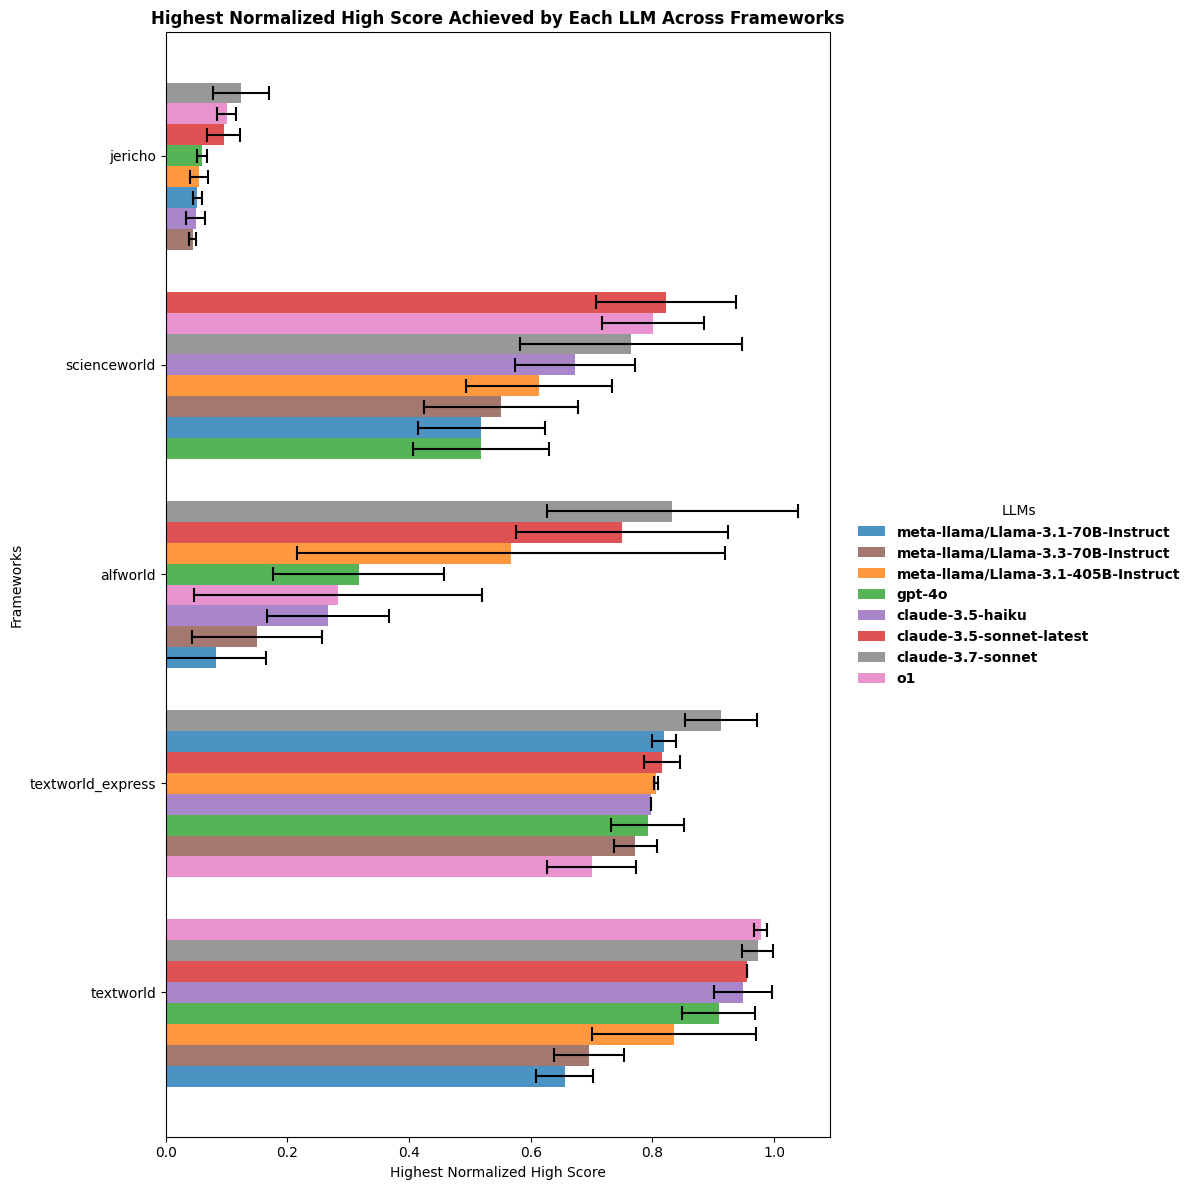

In [86]:
def make_bar_chart_horizontal(llms, frameworks):
    framework_indicies = []
    for framework in frameworks:
        framework_indicies.append(fws.index(framework) + 1) # +1 to deal with model name offset
    framework_indicies = sorted(framework_indicies)

    # Filter the scores_per_framework array based on the llms and frameworks
    # Filter the stds_per_framework array based on the llms and frameworks
    filtered_scores_per_framework = []
    filtered_stds_per_framework = []
    for i, row in enumerate(scores_per_framework):
        if row[0] not in llms: continue
        new_row_scores = [row[0]]
        new_row_stds = []
        for idx in framework_indicies: 
            new_row_scores.append(row[idx])
            new_row_stds.append(stds_per_framework[i][idx])

        filtered_scores_per_framework.append(new_row_scores)
        filtered_stds_per_framework.append(new_row_stds)

    framework_names = frameworks
    transposed_std_per_framework = np.transpose(filtered_stds_per_framework)
    llm_names = llms
    framework_scores_sets = []
    framework_std_sets = []
    for i, row in enumerate(np.transpose(filtered_scores_per_framework)[1:]):
        framework_scores_sets.append([float(score) for score in row])
        framework_std_sets.append([float(std) for std in transposed_std_per_framework[i]])
    # Sort scores, standard deviations, and LLM names for each framework
    sorted_framework_scores_sets = []
    sorted_framework_std_sets = []
    sorted_llm_names_sets = []

    # For each framework, create a mapping from LLM to its color to maintain color consistency
    llm_to_color = {llm: plt.cm.tab10(i % 10) for i, llm in enumerate(llm_names)}

    for framework_name, framework_scores, framework_stds in zip(framework_names, framework_scores_sets, framework_std_sets):
        # Pair scores with their corresponding LLM names and standard deviations
        paired_data = list(zip(framework_scores, framework_stds, llm_names))
        
        # Sort the pairs by score
        paired_data.sort(key=lambda pair: pair[0])
        
        # Unzip the sorted pairs back into separate lists
        sorted_scores, sorted_stds, sorted_llms = zip(*paired_data)
        sorted_framework_scores_sets.append(sorted_scores)
        sorted_framework_std_sets.append(sorted_stds)
        sorted_llm_names_sets.append(sorted_llms)

    # Create a bar chart
    fig, ax = plt.subplots(figsize=(10, 12))  # Swap dimensions for horizontal orientation

    # Bar height and positions
    bar_height = 0.8 / len(llm_names)  # Dynamically adjust bar height based on the number of LLMs
    y = range(len(framework_names))  # Y-axis positions for frameworks

    # Create a set to track which LLMs have been added to the legend
    legend_added = set()

    # Plot bars for each framework
    for i, (framework_name, sorted_scores, sorted_stds, sorted_llms) in enumerate(zip(
        framework_names, sorted_framework_scores_sets, sorted_framework_std_sets, sorted_llm_names_sets)):
        for j, (llm_name, score, std) in enumerate(zip(sorted_llms, sorted_scores, sorted_stds)):
            # Add to legend only if this LLM hasn't been added yet
            if llm_name not in legend_added:
                label = llm_name
                legend_added.add(llm_name)
            else:
                label = ""
            
            # Calculate y position for the bar
            y_pos = y[i] + j * bar_height - (len(sorted_llms) * bar_height) / 2
            
            # Draw the horizontal bar
            ax.barh(
                y_pos,
                score,
                height=bar_height,
                label=label,
                color=llm_to_color[llm_name],  # Use consistent colors for each LLM
                alpha=0.8
            )
            
            # Add error bars (horizontal now)
            ax.errorbar(
                score,
                y_pos,
                xerr=std,
                fmt='none',  # No line connecting error bars
                ecolor='black',  # Color of error bars
                capsize=5,  # Size of caps at the end of error bars
                capthick=1.5,  # Thickness of caps
                elinewidth=1.5  # Thickness of error bar lines
            )

    # Set y-axis labels and ticks
    ax.set_yticks(y)  # Center the ticks
    ax.set_yticklabels(framework_names)  # Set framework names as y-axis labels

    # Add labels and title
    ax.set_xlabel('Highest Normalized High Score')
    ax.set_ylabel('Frameworks')
    ax.set_title('Highest Normalized High Score Achieved by Each LLM Across Frameworks', fontweight='bold')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles, labels,
        title="LLMs",
        loc='center left',
        bbox_to_anchor=(.85, 0.5),  # Reduced from 1.05 to 1.01 to move closer to plot
        ncol=1,  # Single column for better readability
        frameon=False,
        fontsize='medium',  # Set the font size for the legend text
        prop={'weight': 'bold'} 
    )
    
    # Adjust layout - make less room on the right for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjusted from 0.75 to 0.85 to reduce whitespace
    plt.show()

make_bar_chart_horizontal(llms = downsampled_llms, 
                 frameworks = fws)

### Make horizontal bar charts per game

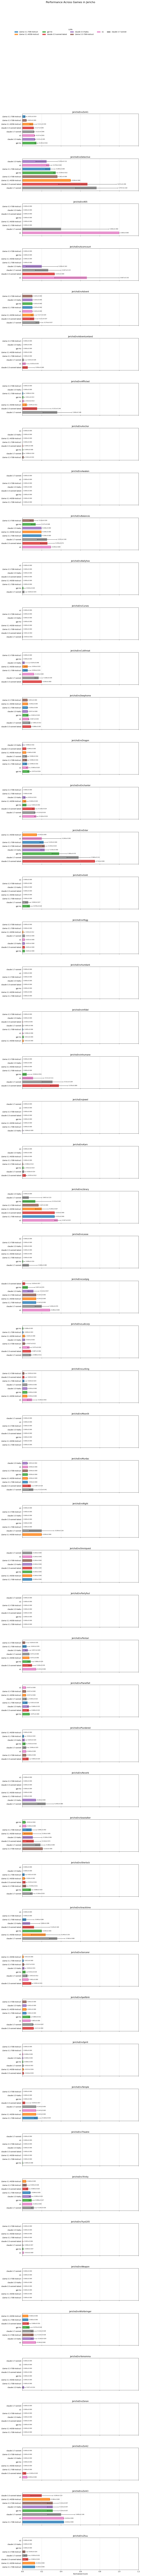

(<Figure size 1200x22000 with 55 Axes>,
 array([<Axes: title={'center': 'JerichoEnvZork1'}>,
        <Axes: title={'center': 'JerichoEnvDetective'}>,
        <Axes: title={'center': 'JerichoEnv905'}>,
        <Axes: title={'center': 'JerichoEnvAcorncourt'}>,
        <Axes: title={'center': 'JerichoEnvAdvent'}>,
        <Axes: title={'center': 'JerichoEnvAdventureland'}>,
        <Axes: title={'center': 'JerichoEnvAfflicted'}>,
        <Axes: title={'center': 'JerichoEnvAnchor'}>,
        <Axes: title={'center': 'JerichoEnvAwaken'}>,
        <Axes: title={'center': 'JerichoEnvBalances'}>,
        <Axes: title={'center': 'JerichoEnvBallyhoo'}>,
        <Axes: title={'center': 'JerichoEnvCurses'}>,
        <Axes: title={'center': 'JerichoEnvCutthroat'}>,
        <Axes: title={'center': 'JerichoEnvDeephome'}>,
        <Axes: title={'center': 'JerichoEnvDragon'}>,
        <Axes: title={'center': 'JerichoEnvEnchanter'}>,
        <Axes: title={'center': 'JerichoEnvEnter'}>,
        <Axes: tit

In [88]:
def make_game_bar_charts(llms, framework, games=None):
    """
    Creates horizontal bar charts showing LLM performance for each game in a specific framework.
    
    Args:
        llms: List of LLM names to include
        framework: The specific framework to analyze
        games: Optional list of games to include (if None, will use all games in the framework)
    """
    # If no games specified, get all games for the framework
    if games is None:
        games = framework_games[framework]
    
    # Create a color mapping for LLMs for consistency
    llm_to_color = {llm: plt.cm.tab10(i % 10) for i, llm in enumerate(llms)}
    
    # Create a figure with subplots - one per game
    n_games = len(games)
    fig, axes = plt.subplots(n_games, 1, figsize=(12, 4 * n_games), sharex=True)
    
    # If there's only one game, make sure axes is still iterable
    if n_games == 1:
        axes = [axes]
    
    # Keep track of the maximum score to set consistent x-axis limits
    max_score = 0
    
    # Process each game
    for game_idx, game in enumerate(games):
        ax = axes[game_idx]
        
        # Collect scores and stds for this game across all LLMs
        game_scores = []
        game_stds = []
        valid_llms = []
        
        for llm in llms:
            try:
                # Get all seeds for this game
                seeds = llm_framework_scores[llm][framework][game]
                
                # Extract scores from all seeds
                scores = [seed_data[0] for seed_data in seeds.values()]
                
                # Calculate mean and std
                mean_score = np.mean(scores)
                std_score = np.std(scores)
                
                game_scores.append(mean_score)
                game_stds.append(std_score)
                valid_llms.append(llm)
                
                # Update max score for x-axis scaling
                if mean_score + std_score > max_score:
                    max_score = mean_score + std_score
                    
            except (KeyError, ValueError):
                # Skip if LLM doesn't have data for this game
                continue
        
        # Sort scores, stds, and LLMs together (highest score first)
        sorted_data = sorted(zip(game_scores, game_stds, valid_llms), key=lambda x: x[0], reverse=True)
        
        # Unpack the sorted data
        if sorted_data:  # Check if there's any data
            sorted_scores, sorted_stds, sorted_llms = zip(*sorted_data)
        else:
            # Skip this game if no data
            ax.set_title(f"{game} (No data)")
            continue
            
        # Set y positions for bars
        y_positions = range(len(sorted_llms))
        
        # Draw horizontal bars
        for i, (llm, score, std) in enumerate(zip(sorted_llms, sorted_scores, sorted_stds)):
            # Draw the bar
            ax.barh(
                i,
                score,
                height=0.7,
                label=llm if game_idx == 0 and i == 0 else "",  # Only add to legend once
                color=llm_to_color[llm],
                alpha=0.8
            )
            
            # Add error bars
            ax.errorbar(
                score,
                i,
                xerr=std,
                fmt='none',
                ecolor='black',
                capsize=3,
                capthick=1,
                elinewidth=1
            )
            
            # Add score value at the end of each bar
            ax.text(
                score + std + 0.01,  # Slight offset from end of error bar
                i,
                f"{score:.3f}±{std:.3f}",
                va='center',
                fontsize=8
            )
        
        # Set y-ticks to be the LLM names
        ax.set_yticks(y_positions)
        shortened_llm_names = [llm.split('/')[-1] for llm in sorted_llms]  # Get just the model name without path
        ax.set_yticklabels(shortened_llm_names)
        
        # Set title for this subplot
        ax.set_title(game)
        
        # Add grid lines
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Only show x-label on the bottom plot
        if game_idx == n_games - 1:
            ax.set_xlabel('Normalized Score')
    
    # Set consistent x-axis limits
    for ax in axes:
        ax.set_xlim(0, max_score * 1.2)  # Add 20% padding
    
    # Create a custom legend with all LLMs
    handles = [plt.Rectangle((0,0), 1, 1, color=llm_to_color[llm], alpha=0.8) for llm in llms]
    shortened_labels = [llm.split('/')[-1] for llm in llms]
    
    fig.legend(
        handles, 
        shortened_labels,
        title="LLMs",
        loc='upper center',
        bbox_to_anchor=(0.5, 0.98),
        ncol=min(5, len(llms)),
        frameon=False
    )
    
    plt.suptitle(f'Performance Across Games in {framework.capitalize()}', fontsize=16, y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the suptitle
    plt.subplots_adjust(hspace=0.4)  # Add space between subplots
    
    plt.show()
    
    return fig, axes

# Example usage for one framework
framework_to_analyze = 'jericho'  # You can replace with any framework from fws
selected_games = framework_games[framework_to_analyze]  # Limit to first 5 games to avoid overcrowding

# Create the bar charts
make_game_bar_charts(
    llms=downsampled_llms, 
    framework=framework_to_analyze,
    games=selected_games
)